###Análise de Sentimentos com LSTM

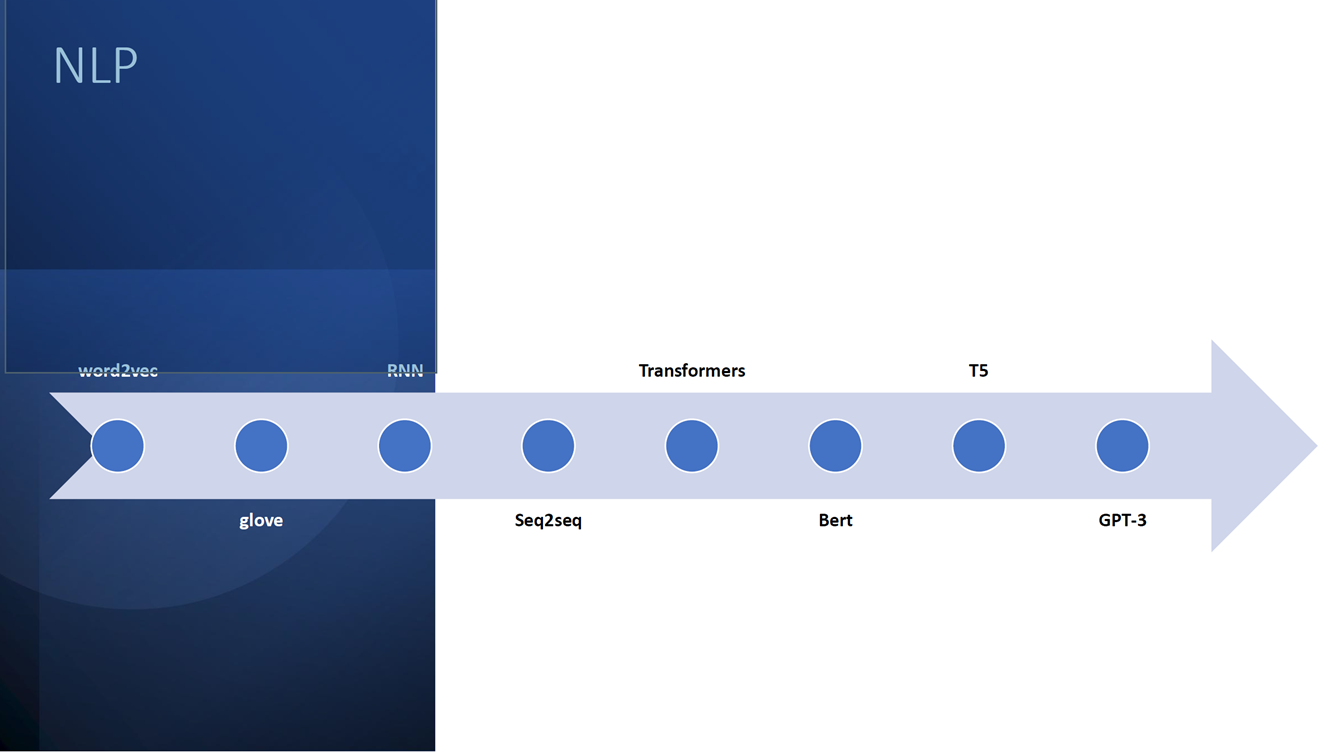

Algumas mudanças em relação ao código anterior:
- Saída da Rede Neural formada por vários neurônios (função de ativação softmax)
- Usar redes LSTM (Long Short Term Memory) que considera ordem das palavras:
  - João é uma nova pessoa
  - João é uma pessoa nova.

In [1]:
!pip install pandas scikit-learn keras numpy


###Por que usar Keras (ou PyTorch) para LSTM?

As redes LSTM são redes neurais recorrentes (RNNs) com estrutura interna complexa, voltadas para dados sequenciais como texto, séries temporais, áudio etc.

O Scikit-learn foi projetado para modelos tradicionais de Machine Learning:

Regressão logística, SVM, árvores de decisão, Naive Bayes etc.

Ele não suporta LSTM, GRU ou redes neurais profundas diretamente.

In [2]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from google.colab import files
import numpy as np

###Redes Neurais Recorrentes (RNN):

As RNNs são uma classe de redes neurais projetadas para lidar com dados sequenciais. Elas são especialmente úteis em tarefas onde a ordem dos elementos nos dados é importante, como em séries temporais, linguagem natural e, é claro, análise de sentimento. A principal característica das RNNs é que elas possuem loops que permitem que as informações persistam.

Imagine que você está lendo uma frase palavra por palavra. Cada palavra que você lê não é apenas interpretada por si só, mas também é influenciada pelas palavras que você leu anteriormente. As RNNs capturam essa ideia ao manterem uma "memória" interna ou estado oculto que é atualizado a cada nova entrada.

No entanto, as RNNs enfrentam um desafio conhecido como "problema do desaparecimento do gradiente", onde informações relevantes podem ser perdidas ao longo do tempo durante o treinamento, tornando-as menos eficazes para lidar com sequências longas.

###Long Short-Term Memory (LSTM):

As LSTMs são uma variação das RNNs que foram projetadas para superar o problema do desaparecimento do gradiente. Elas introduzem unidades de memória especiais que têm a capacidade de lembrar ou esquecer informações ao longo do tempo.

Cada célula LSTM possui três portas principais: a porta de entrada (input gate), a porta de esquecimento (forget gate) e a porta de saída (output gate). Essas portas regulam o fluxo de informações na célula, permitindo que ela aprenda a lembrar ou esquecer informações com base nas entradas.

A arquitetura das LSTMs ajuda a manter informações importantes por períodos mais longos, tornando-as mais adequadas para tarefas que envolvem sequências longas, como a análise de sentimento em textos mais extensos.

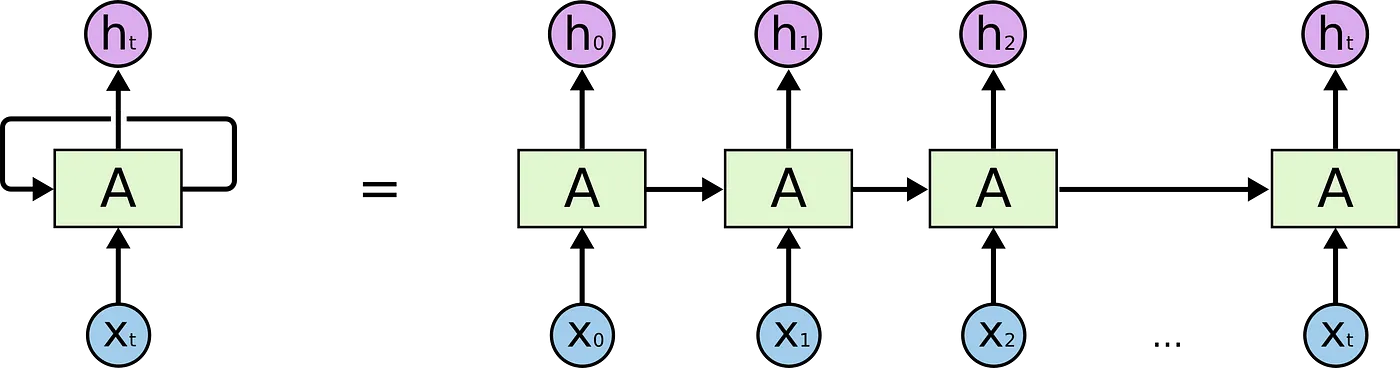

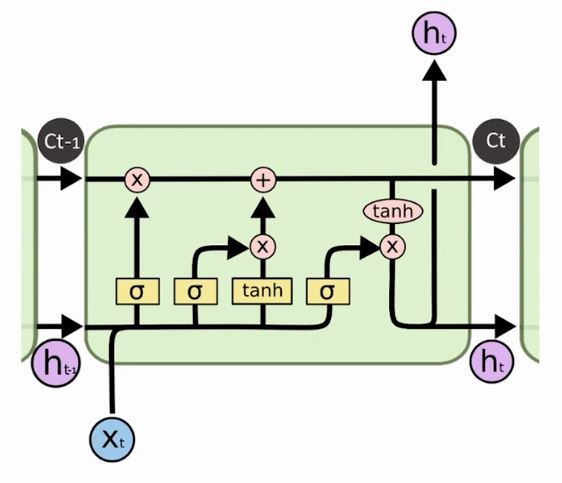

In [3]:
files.upload()

Output hidden; open in https://colab.research.google.com to view.

In [4]:
Tweets = pd.read_csv("Tweets.csv")
Tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,3.486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,6.837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0,Bad Flight,7.033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0,Can't Tell,1.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


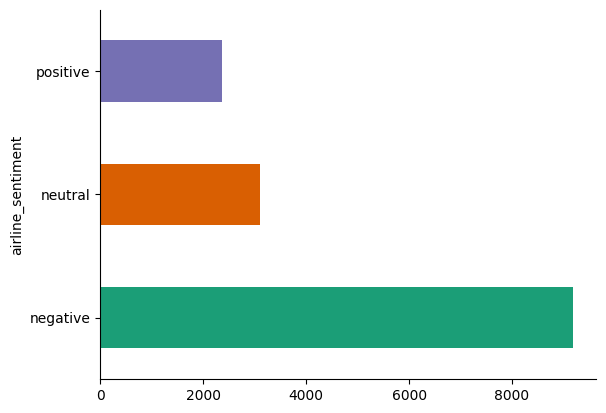

In [6]:
# @title airline_sentiment

from matplotlib import pyplot as plt
import seaborn as sns
Tweets.groupby('airline_sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [7]:
Tweets.groupby(['airline_sentiment']).size()

,0
airline_sentiment,
negative,9178
neutral,3099
positive,2363


In [8]:
# Converte a coluna para tipo numérico (ignora erros de conversão, se houver)
Tweets['airline_sentiment_confidence'] = pd.to_numeric(Tweets['airline_sentiment_confidence'], errors='coerce')

# Remove valores NaN resultantes de conversão falha, se necessário
Tweets = Tweets.dropna(subset=['airline_sentiment_confidence'])

# Filtra os tweets com confiança maior que 0.99
Tweets = Tweets[Tweets['airline_sentiment_confidence'] > 0.99]

In [9]:
Tweets.groupby(['airline_sentiment']).size()

,0
airline_sentiment,
negative,9093
neutral,3030
positive,2311


In [10]:
Tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,3.486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,6.837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.000,Bad Flight,7.033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.000,Can't Tell,1.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [11]:
#num_words é o número de tokens
token = Tokenizer(num_words=1000)
#criando o vocabulário a partir dos tweets, em seguida, criando o modelo
token.fit_on_texts(Tweets['text'].values)

In [12]:
#gerando a representação vetorizada dos tokens
X = token.texts_to_sequences(Tweets['text'].values)
print(X)
#completando os vetores com 0s à direita
X = pad_sequences(X, padding="post", maxlen=100)

[[81, 62, 226], [81, 560, 580, 1, 2, 201], [81, 3, 207, 102, 796, 597, 3, 76, 1, 152, 148, 195], [81, 90, 137, 1, 15, 21, 59, 56, 22, 504], [81, 10, 90, 4, 137, 489, 215, 490, 84, 20], [81, 435, 77, 288, 223, 4, 8, 7, 197, 27, 207, 22, 29, 90, 137, 2, 118, 215, 490, 84, 129], [81, 175, 315, 51, 3, 108, 29, 133, 456], [81, 137, 286, 4, 7, 346, 73, 589, 32, 34], [81, 236, 3, 42, 3, 46], [81, 20, 23, 370, 10, 568, 43, 91, 355, 237, 174, 144, 1, 19], [81, 121, 6, 114, 27, 14, 2, 614, 774, 18, 213, 424], [81, 3, 737, 100, 703, 47, 183, 217, 166], [81, 29, 14, 569, 4, 119, 676, 224, 84, 11, 647, 195, 1, 59, 3, 392, 140, 948, 9, 11, 358, 195, 254], [81, 58, 129, 21, 105, 117, 152, 69, 2, 456, 33, 172, 36, 32, 34], [81, 39], [81, 294, 848, 14, 72, 760], [81, 47, 949, 7, 11, 153, 870, 8, 256, 1, 626, 128, 581, 252, 31, 119, 542, 84, 924], [81, 3, 677, 33, 457, 1, 294, 135, 310, 10, 380, 481, 15, 11, 150, 170, 1, 187, 9, 704, 18, 19, 49], [3, 129, 81], [81, 6, 114, 62, 77, 35, 298, 371, 532, 75,

In [13]:
print(X)

[[ 81  62 226 ...   0   0   0]
 [ 81 560 580 ...   0   0   0]
 [ 81   3 207 ...   0   0   0]
 ...
 [ 13  75 664 ...   0   0   0]
 [ 13   6  22 ...   0   0   0]
 [ 13  41  22 ...   0   0   0]]


In [14]:
labelencoder = LabelEncoder()
y = labelencoder.fit_transform(Tweets['airline_sentiment'])
print(y)

[1 2 1 ... 1 0 1]


In [15]:
#aplicando o one hot encoding
y = to_categorical(y)
print(y)

[[0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3)
X_test

array([[ 16,   3,   1, ...,   0,   0,   0],
       [ 13, 547, 214, ...,   0,   0,   0],
       [ 16, 342, 142, ...,   0,   0,   0],
       ...,
       [ 12,  46,   6, ...,   0,   0,   0],
       [ 17,  18,  11, ...,   0,   0,   0],
       [ 16, 256,  14, ...,   0,   0,   0]], dtype=int32)

In [17]:
print(len(token.word_index))

15628


In [18]:
X.shape[1]

100

In [19]:
#Lembrando:
# input_dim (Dimensão de Entrada) é o número total de palavras únicas no seu vocabulário.
# output_dim (Dimensão de Saída): é o número de dimensões no qual cada palavra será representada.
# input_length (Comprimento de Entrada) é o comprimento máximo das sequências de palavras de entrada.
modelo = Sequential()
# Camada de Embedding: Vetores densos, aprendidos durante o treinamento da rede, sem contexto, mas com semântica local.
modelo.add(Embedding(input_dim= len(token.word_index), output_dim=128))
#A SpatialDropout1D é uma variação do dropout a qual, em vez de desativar unidades individuais,
# ela desativa conjuntos inteiros de neurônios ao longo do tempo
modelo.add(SpatialDropout1D(0.2))
#criando a rede neural recorrente LSTM
#modelo.add(LSTM(units=196, dropout=0.2, recurrent_dropout=0.2))
modelo.add(LSTM(units=512, dropout=0.2, recurrent_dropout=0, activation='tanh',
                recurrent_activation='sigmoid', unroll=False, use_bias=True))
# Nova Camada Densa (Fully Connected)
modelo.add(Dense(units=128, activation='relu'))

# Camada de Dropout para Regularização
modelo.add(Dropout(0.5))
# obrigatoriamente 3 neurônios na saída, e softmax como função de ativação
modelo.add(Dense(units=3,activation="softmax"))


A biblioteca CuDNN (CUDA Deep Neural Network library) é uma biblioteca de alto desempenho desenvolvida pela NVIDIA para acelerar operações relacionadas a redes neurais profundas em GPUs NVIDIA. Ela é projetada para ser usada em conjunto com a API de computação paralela CUDA (Compute Unified Device Architecture).

In [20]:
#A categorical crossentropy é adequada quando você está lidando com um problema de
# classificação com mais de duas classes e suas labels estão one-hot encoded.
modelo.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])


In [21]:
modelo.fit(X_train, y_train, epochs=10, batch_size=30,verbose=True,validation_data=(X_test, y_test))

Epoch 1/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.6108 - loss: 0.9516 - val_accuracy: 0.6384 - val_loss: 0.9076
Epoch 2/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.6263 - loss: 0.9261 - val_accuracy: 0.6384 - val_loss: 0.9000
Epoch 3/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.6270 - loss: 0.9266 - val_accuracy: 0.6384 - val_loss: 0.8997
Epoch 4/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.6303 - loss: 0.9166 - val_accuracy: 0.6384 - val_loss: 0.9007
Epoch 5/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.6334 - loss: 0.9161 - val_accuracy: 0.6384 - val_loss: 0.9004
Epoch 6/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.6178 - loss: 0.9340 - val_accuracy: 0.6384 - val_loss: 0.9048
Epoch 7/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.6256 - loss: 0.9226 - val_accuracy: 0.6384 - val_loss: 0.9035
Epoch 8/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.6267 - loss: 0.9204 - v

In [22]:
loss, accuracy = modelo.evaluate(X_test,y_test)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6447 - loss: 0.8948
Loss:  0.9015567302703857
Accuracy:  0.6384207010269165


In [23]:
prev = modelo.predict(X_test)
print(prev)

136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
[[0.6247566  0.20363618 0.17160715]
 [0.62236077 0.20512195 0.17251727]
 [0.6217972  0.20542894 0.17277382]
 ...
 [0.624429   0.20373033 0.17184071]
 [0.6236321  0.20403798 0.17232998]
 [0.6229081  0.204743   0.17234889]]


In [24]:
# Texto de entrada para previsão
texto_entrada = "I am so sad TODAY!!!!"

# Pré-processamento do texto
texto_entrada = [texto_entrada]  # Transforme em lista porque o tokenizer espera uma lista
sequencias_texto = token.texts_to_sequences(texto_entrada)
texto_codificado = pad_sequences(sequencias_texto, maxlen=100)

# Fazer a previsão
previsao = modelo.predict(texto_codificado)

print(previsao)

# Interpretar a saída
rotulo_previsao = np.argmax(previsao, axis=1)
print("Sentimento Previsto:", rotulo_previsao)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
[[0.5928662  0.22012347 0.18701036]]
Sentimento Previsto: [0]
